In [1]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU'
device_name = 'CPU' 
print(f'device name {device_name}')
import os
import sys

from math import cos,sin,tan,asin,acos,radians,sqrt,degrees,atan,atan2,copysign
import numpy as np

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pickle
import scipy
from scipy.stats import norm
import random
import time
import timeit
import math
import localization as lx
import gzip

import util.npose_util as nu
import datetime
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import cKDTree


import joblib
from sklearn.manifold import MDS
import argparse
from functools import partial
from itertools import starmap,repeat,permutations

from pymol import cmd, stored, selector

import GenerateEndpoints as ge
import HelixFit as hf
import FitTransform as ft

import seaborn as sns
import util.RotationMethods as rm

#reference helix for propogation
zero_ih = nu.npose_from_file('util/zero_ih.pdb')
tt = zero_ih.reshape(int(len(zero_ih)/5),5,4)
stub = tt[7:10].reshape(15,4)

np.set_printoptions(precision=2)


device name CPU


In [2]:
# #load distance maps and endpoints dataset
# def load_distance_map(name, dm_file='data/Fits_4H_dm_phi.npz'):
#     rr = np.load(dm_file, allow_pickle=True)
#     X_train, y_train , featNames = [rr[f] for f in rr.files]
    
    
#     return X_train[y_train==name][:,:-4]

# dm_file = 'data/Fits_4H_dm_phi.npz'
# rr = np.load(dm_file, allow_pickle=True)
# X_train, y_train , featNames = [rr[f] for f in rr.files]
# # = 'data/4H_dataset/models/'
# # cmd.load(f'{model_direc}{y_train[0]}.pdb')
# # cmd.save(f'output/test.pdb')

# #endpoints for data set 
# Fits4H_file = 'data/Fits_4H.csv'
# dfRead = pd.read_csv(Fits4H_file)
# df1 = ft.prepData_Str(dfRead,rmsd_filter=100)
# df2 = ft.EndPoint(df1)
# ep = df2.to_numpy()[:,:24].astype(float).reshape((-1,8,3))
# X = ep
#np.savez_compressed('data/ep_for_X.npz', ep=X)
rr = np.load(f'data/ep_for_X.npz', allow_pickle=True)
X = [rr[f] for f in rr.files][0]

In [95]:
def index_helix_ep(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    hi = np.array(helices_desired,dtype=int)
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    #alternate example for indexing batch of X 
    #X.reshape((X.shape[0],-1))[:,indexarray]
    
    #select desired endpoints from  batch of endpoints
    return ep_in[np.ix_(np.array(range(ep_in.shape[0])),h_ep[hi].flatten(), np.array(range(ep_in.shape[2])))]
    
def get_midpoint(ep_in,helices_desired=[0,1],num_helices=4):
    
    num_ep = num_helices*2
    
    ind_ep = index_helix_ep(ep_in, helices_desired=helices_desired, num_helices=4)
    
    #calculate midpoint
    midpoint = ind_ep.sum(axis=1)/np.repeat(ind_ep.shape[1], ind_ep.shape[2])
    
    return midpoint

def get_stubs_from_points(ep_in,index=[0,1,2]):
#def get_stubs_from_n_ca_c(n, ca, c):
    """Modified from Brian's npose code  get_stubs_from_n_ca_c, index references 3 points, to define plane.
    """
    e1 = ep_in[:,index[1]]-ep_in[:,index[0]]
    e1 = np.divide( e1, np.linalg.norm(e1, axis=1)[..., None] )

    e3 = np.cross( e1, ep_in[:,index[2]]-ep_in[:,index[0]], axis=1 )
    e3 = np.divide( e3, np.linalg.norm(e3, axis=1)[..., None] )

    e2 = np.cross( e3, e1, axis=1 )

    stub = np.zeros((len(ep_in), 4, 4))
    stub[...,:3,0] = e1
    stub[...,:3,1] = e2
    stub[...,:3,2] = e3
    stub[...,:3,3] = ep_in[:,index[1]]
    stub[...,3,3] = 1.0

    return stub

def xform_npose_2batch(xform, npose):
    #single batch code  util.npose_util as xform_npose
    return np.matmul(np.repeat(xform[:,np.newaxis,...],npose.shape[1],axis=1),npose[...,None]).squeeze(-1)

def xform_to_z_plane(mobile, index_mobile=[0,1,2]):
    """rotate points into the z-plane for trilaterization. needs additional translation/reflection"""

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)
    
    z_plane_ref = np.repeat(np.array([[[0,0,0],[1,0,0],[1,1,0]]]), mobile.shape[0],axis=0)

    ref_stub = get_stubs_from_points(z_plane_ref, index=[0,1,2])

    xform = ref_stub @ mobile_stub_inv

    return xform


def rotate_base_tri_Zplane(endpoint_midpoints, target_point=4, index_mobile=[1,2,3], returnRotMat=False):
    """rotate points into the z-plane for trilaterization. Target point ensures that point is positive in Z"""
    tp = target_point #target point
    zplanexform = xform_to_z_plane(endpoint_midpoints,index_mobile=index_mobile) #one index start base triangle, default
    #add one for npose rot calc
    npose = np.concatenate((endpoint_midpoints, np.ones((endpoint_midpoints.shape[0],
                                                         endpoint_midpoints.shape[1],1))),axis=2) 
    rot = xform_npose_2batch(zplanexform,npose) # double batch matrix multiplication, see npose, for one batch

    #translate X domain to place first index of "index_mobile" to 0,0,0
    rot[:,:,0] = rot[:,:,0]-np.expand_dims(rot[:,index_mobile[0],0],axis=1)
    #based on target point guaranteed to be positive
    #reflect new points across the z axis to positive if negative to match just choosing positive solutions
    rot[...,2][rot[:,tp,2]<0] = -rot[...,2][rot[:,tp,2]<0]
    
    if not returnRotMat:
        return rot[...,:3] #remove npose rotate dimension
    else:
        return rot[...,:3], zplanexform

In [4]:
#methods to index needed indices from generator

def helix_dindex(helices_to_keep, num_helices=4, intraHelixDist=True):
    """Get index values for parts of the distance map"""
    
    #prep indices for distance map
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    helix_used = np.array(helices_to_keep,dtype=int)
    
    h_ep = np.array(range(num_ep)).reshape((-1,2)) #generate helix to endpoint mapping
    
    tot_ind = []
    
    if intraHelixDist:
        #get indices of distance map that correspond to each helix, overlap is distances between specified endpoints
        for x in helix_used:
            new_ind = np.intersect1d(mat_ind[h_ep[x]], mat_ind.T[h_ep[x]])
            tot_ind.extend(new_ind)
    
    
    for x in permutations(helix_used,2):
        new_ind = np.intersect1d(mat_ind[h_ep[x[0]]], mat_ind.T[h_ep[x[1]]])
        tot_ind.extend(new_ind)
    
    #convert to generator indices (indices of iu1 array)
    out_ind = []
    for x in tot_ind:
        if len(np.nonzero(mat_ind[iu1]==x)[0])>0:
            out_ind.append(np.nonzero(mat_ind[iu1]==x))

    return np.sort(np.array(out_ind).flatten())


def point_dindex(target_points, ref=[4], num_helices = 4):
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    dindex = []
    
    for tp in target_points:
        for ref_ind in ref:
            dindex.append(mat_ind[ref_ind,tp]) #indices for distances to target point
    
    dindex = np.array(dindex)
    
    out_ind = []
    for x in dindex.flatten():
        out_ind.append(np.nonzero(mat_ind[iu1]==x))
        
    out_ind = np.array(out_ind)
    
    return out_ind.reshape((len(target_points),-1))

def target_dindex(target_points, oneRef = True, num_helices = 5, baseTri_out=True):
    """Distance map indices for base triangle and output distance map"""
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)

    if oneRef:
        ref = [1,2,3]
        base_tri = [mat_ind[1][2],mat_ind[2][3],mat_ind[1][3]] #p1 to p2, p2 to p3, p1 to p3
        
    else:
        ref = [0,1,2]
        base_tri = [mat_ind[0][1],mat_ind[1][2],mat_ind[0][3]] #p0 to p1, p1 to p2, p0 to p3
    
    dindex = []
    
    for tp in target_points:
        dindex.append(mat_ind[ref,tp]) #indices for distances to target point
    
    dindex = np.array(dindex)
    
    out_ind = []
    for x in dindex.flatten():
        out_ind.append(np.nonzero(mat_ind[iu1]==x))
        
    out_ind = np.array(out_ind)
    
    return out_ind.reshape((-1,len(base_tri))),base_tri

def minMax_indices(distance_index, point_index, minmax_obj):
    
    #assemble conversions 
    #converts output from generator back to real distances
    dMin_all = tf.convert_to_tensor(minmax_obj.data_min_, dtype=tf.float32)
    mScale_all = tf.convert_to_tensor(minmax_obj.scale_, dtype = tf.float32)
    mMin = tf.convert_to_tensor(minmax_obj.feature_range[0], dtype = tf.float32)

    #index just the distances we need for calculation
    dMin = tf.gather(dMin_all, distance_index,axis=0)
    mScale = tf.gather(mScale_all, distance_index,axis=0)

    #indexes we need to determine the +/- z value of the new points
    pindex = point_dindex([5,6,7], ref=[4], num_helices = 4)
    dMin_nwp = tf.gather(dMin_all, point_index,axis=0)
    mScale_nwp = tf.gather(mScale_all, point_index,axis=0)
    
    return dMin, mScale, mMin, dMin_nwp,  mScale_nwp 

def ref_distmap_index(distances, num_helices = 4):
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    iu1_flat = iu1[0]*num_ep+iu1[1]
    
    return distances[np.ix_(range(distances.shape[0]),iu1_flat)]

def convert_dMat_to_iu1_index(indices_in, num_helices = 4):
    """Converts indices on flattened distance index to iu1 single indices"""
    
    
    conv_array = np.array(indices_in).flatten()
    
    num_ep = num_helices*2
    mat_ind = np.array(range((num_ep)**2)).reshape((num_ep,num_ep))
    iu1 = np.triu_indices(num_ep, 1)
    
    #convert to generator indices (indices of iu1 array)
    out_ind = []
    for x in conv_array:
        if len(np.nonzero(mat_ind[iu1]==x)[0])>0:
            out_ind.append(np.nonzero(mat_ind[iu1]==x))
            
    out_ind = np.array(out_ind)
        
    return out_ind.reshape(conv_array.shape)

In [5]:
def prep_base_triangle_trilateriation(dindex, base_tri, distance_map):
    """Return x,y,z coords on z-plane of base triangle of tetrahedron from a distance map."""
    
#     dindex, base_tri = target_dindex(targ_dind, oneRef = oneRef, num_helices = num_helices)
# #     print(dindex)
# #     print(base_tri)
    
    #test case input data: prep base triangles for trilateration at zplane, (0,0,0) (dvar,0,0) (ivar,jvar,0)
    desired_dm = distance_map[:, base_tri] #base tri from dindex

    dvar_index = tf.convert_to_tensor(0 ,dtype=tf.int32)
    s2_index = tf.convert_to_tensor(2 ,dtype=tf.int32) # we would like the angle across from side 2
    s3_index = tf.convert_to_tensor(1 ,dtype=tf.int32)

    #x value representing center of 2nd sphere at (dvar,0,0) aka s1
    dvar = tf.reshape(tf.gather(desired_dm, dvar_index,axis=1),(-1,1)) #side 1
    s2 = tf.reshape(tf.gather(desired_dm,   s2_index,axis=1),(-1,1))
    s3 = tf.reshape(tf.gather(desired_dm,   s3_index,axis=1),(-1,1))

    #calculate the opposite angle of the the third side of base triangle using law of cosines
    s1sq = tf.square(dvar)
    s2sq = tf.square(s2)
    s3sq = tf.square(s3)
    ang3 = np.arccos((-s3sq+s2sq+s1sq)/(2*dvar*s2))

    #take third point of base triangle via distance * vector
    v13 = tf.concat([tf.cos(ang3), tf.sin(ang3), tf.zeros_like(ang3)], axis=1)
    p3 = s2*v13
    #center points of 3rd sphere
    ivar = tf.reshape(p3[:,0],(-1,1))
    jvar = tf.reshape(p3[:,1],(-1,1))


    #convert all to float32 to match generator output
    #expand to dindex size 

    dvar = tf.cast(tf.repeat(dvar,dindex.shape[0],axis=1),dtype=tf.float32)
    ivar = tf.cast(tf.repeat(ivar,dindex.shape[0],axis=1),dtype=tf.float32)
    jvar = tf.cast(tf.repeat(jvar,dindex.shape[0],axis=1),dtype=tf.float32)
    
    return dvar, ivar, jvar


In [6]:
def buttress_via_mask_only(gen_obj, ref_map, target_mp, batch_size=32,cycles=100, input_z=None, 
                          rate=0.05, target_ep=[4,5,6,7], num_helices=4, oneRef=True,
                          scale=5.0, z_size=12):
    
    
    batch = batch_size*ref_map.shape[0]
    ref_map = np.repeat(ref_map, batch_size, axis=0)
    
    #input to generator (determinstic output)
    if input_z is None:
        input_z = tf.random.uniform(shape=(batch, z_size), minval=-1, maxval=1)
        
    input_z_var = tf.Variable(input_z)
    
    #establish indices for distances to reference
    #prep base triangle, convert distances from minmax to regular
    dindex, base_tri = target_dindex(target_ep, oneRef = True, num_helices = num_helices)
    base_tri = convert_dMat_to_iu1_index(base_tri) #dirty
    pindex = point_dindex(target_ep[1:], ref=[target_ep[0]], num_helices = num_helices)

    #convert generator output to 'real distances'
    #dMin, mScale, mMin, dMin_nwp,  mScale_nwp = minMax_indices(dindex, pindex, brec.mm)
    mmTuple = minMax_indices(dindex, pindex, gen_obj.mm)

    # prepare base triangle for trilateriation (z plane , p1 at origin, p2 positive x)
    #dvar, ivar, jvar = prep_base_triangle_trilateriation(dist[:batch], targ_dind = [4,5,6,7], oneRef = True, num_helices=4)
    #baseTuple = prep_base_triangle_trilateriation(dist[:batch], targ_dind = target_ep, oneRef = True, num_helices=num_helices)

    baseTuple = prep_base_triangle_trilateriation(dindex, base_tri, ref_map)
    
    
    #mask for keeping buttress helices in same orientation
    h_index = helix_dindex([0,1], num_helices=4, intraHelixDist=True)
    helix_keep_mask = np.zeros((ref_map.shape[1],),dtype=np.int32)
    helix_keep_mask[h_index] = 1
    helix_keep_mask = tf.convert_to_tensor(helix_keep_mask,dtype=tf.float32)
    
    #store grads and inputs as we backpropagate
    z=[]
    grads = []

    scale = tf.constant(scale)
    ref_map_conv = gen_obj.mm.transform(ref_map)
    ref_map_conv = tf.convert_to_tensor(ref_map_conv,dtype=tf.float32)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=rate)

    g_o = gen_obj.g(input_z_var)
    masked_loss = maskLoss(ref_map_conv, g_o, helix_keep_mask)
    mp_loss  = tf.divide(midpoints_loss(g_o, target_mp, mmTuple, baseTuple, dindex, pindex, batch), scale)
    loss = tf.reduce_sum(mp_loss,axis=1) + tf.reduce_sum(masked_loss,axis=1)

    print('start_masked',np.round(np.sum(masked_loss),2))
    print('start_mp',np.round(np.sum(mp_loss),2))


    for t in range(1,cycles):

        #compute Loss
        with tf.GradientTape() as g_tape:
            g_tape.watch(input_z_var)
            g_o = gen_obj.g(input_z_var)
            masked_loss = maskLoss(ref_map_conv, g_o, helix_keep_mask)
            mp_loss  = tf.divide(midpoints_loss(g_o, target_mp, mmTuple, baseTuple, dindex, pindex, batch),scale)

#             loss = tf.reduce_sum(mp_loss,axis=1) + tf.reduce_sum(masked_loss,axis=1)

        g_grads = g_tape.gradient(masked_loss, input_z_var)

        optimizer.apply_gradients(zip([g_grads],[input_z_var]))
        
        z.append(tf.identity(input_z_var))

    print('end_masked', np.round(np.sum(masked_loss),2))
    print('end_mp', np.round(np.sum(mp_loss),2))
    
    return z

In [7]:
def fullBUTT_GPU(gen_obj, ref_map, target_mp, batch_size=32,cycles=100, input_z=None, 
                          rate=0.05, target_ep=[4,5,6,7], num_helices=4, oneRef=True,
                          scale=5.0, z_size=12):
    
    batch_indices = np.repeat(np.array(range(ref_map.shape[0])),batch_size)
    batch = batch_indices.shape[0]
    ref_map = np.repeat(ref_map, batch_size, axis=0)
    
    #establish indices for distances to reference
    #prep base triangle, convert distances from minmax to regular
    dindex, base_tri = target_dindex(target_ep, oneRef = True, num_helices = num_helices)
    base_tri = convert_dMat_to_iu1_index(base_tri) #dirty
    pindex = point_dindex(target_ep[1:], ref=[target_ep[0]], num_helices = num_helices)

    #convert generator output to 'real distances'
    #dMin, mScale, mMin, dMin_nwp,  mScale_nwp = minMax_indices(dindex, pindex, brec.mm)
    mmTuple = minMax_indices(dindex, pindex, gen_obj.mm)

    # prepare base triangle for trilateriation (z plane , p1 at origin, p2 positive x)
    #dvar, ivar, jvar = prep_base_triangle_trilateriation(dist[:batch], targ_dind = [4,5,6,7], oneRef = True, num_helices=4)
    #baseTuple = prep_base_triangle_trilateriation(dist[:batch], targ_dind = target_ep, oneRef = True, num_helices=num_helices)

    baseTuple = prep_base_triangle_trilateriation(dindex, base_tri, ref_map)
    
    dMin, mScale, mMin, dMin_nwp,  mScale_nwp = mmTuple
    dvar,ivar,jvar = baseTuple
    
    #mask for keeping buttress helices in same orientation
    h_index = helix_dindex([0,1], num_helices=4, intraHelixDist=True)
    helix_keep_mask = np.zeros((ref_map.shape[1],),dtype=np.int32)
    helix_keep_mask[h_index] = 1
    helix_keep_mask = tf.convert_to_tensor(helix_keep_mask,dtype=tf.float32)
    
    @tf.function
    def maskLoss(y_actual, y_pred,mask):
        """Loss Function for mantaing shape of input helices"""
        custom_loss_val = tf.multiply(mask,tf.square(y_actual-y_pred))
        return custom_loss_val

    @tf.function
    def midpoints_loss(g1, target, 
                       dvar, ivar, jvar,
                       dMin, mScale, mMin, dMin_nwp, mScale_nwp, 
                       dindex, pindex, batch_size, zr_ind, z_reflect_tensor):
        """Loss function to move output of two generated helices to target midpoint"""


        #now using dindex gather the desired indices for tetrahedron calcs

        #radius of the spheres, aka the distances to unmasked endpoints
        g2 = tf.gather(g1,dindex,axis=1)

        #see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
        #inspect .scale_
        conv_dist = tf.add(tf.divide(tf.subtract(g2, mMin), mScale),dMin)
        #transpose lets you easily grab all distances with gather/axis 
        conv_dist_squared = tf.transpose(tf.square(conv_dist),perm=[0, 2, 1]) 

        r1_sq = tf.gather(conv_dist_squared, 0, axis=1) 
        r2_sq =  tf.gather(conv_dist_squared,1, axis=1) 
        r3_sq = tf.gather(conv_dist_squared, 2, axis=1)

        #calculate coordinates of spherial intersect
        x = tf.divide(tf.add(tf.subtract(r1_sq,r2_sq),tf.square(dvar)),tf.multiply(2.0,dvar))
        y1 = tf.divide(tf.add(tf.add(tf.subtract(r1_sq,r3_sq), tf.square(ivar)), tf.square(jvar)),tf.multiply(2.0,jvar))
        y = tf.subtract(y1,tf.multiply(tf.divide(ivar,jvar),x))

        pre_z = tf.subtract(tf.subtract(r1_sq,tf.square(x)),tf.square(y))
        fixed_z = tf.clip_by_value(pre_z, 1e-10, 100)

        #adds  to negative values to 0 for sqrt,
        #I think is okay as zero z will imply lengthening of distances to match a non-zero target midpoint,
        #pushing the network in the desired direction?

        z = tf.sqrt(fixed_z) #assume positive solution
        z_neg = tf.multiply(z,-1) #assume negative soluation

        #new points, with both assumptions
        nwp = tf.concat((tf.reshape(x,(batch_size,-1,1)),
                        tf.reshape(y,(batch_size,-1,1)),
                        tf.reshape(z,(batch_size,-1,1))), axis=2)  #

        nwp_negz = tf.concat((tf.reshape(x,(batch_size,-1,1)),
                        tf.reshape(y,(batch_size,-1,1)),
                        tf.reshape(z_neg,(batch_size,-1,1))), axis=2)  #

        #some positive solutions assumptions,
        # assume first [i4] is actual positive use remaining distances of i4 to (i5,i6,i7) to determine z sign
        # closest to matching distance is used


        #let's start by calculating all i4 to (i5,i6,i7) distances

        #stop the gradients since these are used to index gather and scatter
        #unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
        nwp_p =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp,axis=2))
        nwp_n =  tf.stop_gradient(tf.expand_dims(nwp,axis=1) - tf.expand_dims(nwp_negz,axis=2))

        nwp_dist_pz = tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(nwp_p), 3)),(-1,4,4)) #distance calc +1e6?
        nwp_dist_nz = tf.reshape(tf.sqrt(tf.reduce_sum(tf.square(nwp_n), 3)),(-1,4,4))  #distance calc

        z_pn_dist_pre_con = tf.gather(g1,pindex,axis=1)
        z_pn_dist = tf.add(tf.divide(tf.subtract(z_pn_dist_pre_con, mMin), mScale_nwp),dMin_nwp)

        #index p4 to p5,p6,p7
        #rewrite as non-slice version of this

        nwp_dist_pz_c = tf.squeeze(tf.gather(tf.gather(nwp_dist_pz, [0], axis=1), [1,2,3], axis=2))
        nwp_dist_nz_c = tf.squeeze(tf.gather(tf.gather(nwp_dist_nz, [0], axis=1), [1,2,3], axis=2))

        nwp_dist_pz_c = tf.expand_dims(nwp_dist_pz_c,axis=2)
        nwp_dist_nz_c = tf.expand_dims(nwp_dist_nz_c,axis=2)
        
        

        # #using a single distance decide the z assumption and apply
        correct_z_assum = tf.abs(z_pn_dist - nwp_dist_nz_c) < tf.abs(z_pn_dist - nwp_dist_pz_c)
        cz = tf.squeeze(tf.multiply(tf.cast(correct_z_assum,tf.int32),-2))
        
        z_reflect_tensor = tf.ones_like(nwp, dtype=tf.int32)
        
        nwp_mult = tf.cast(tf.tensor_scatter_nd_add(z_reflect_tensor, z_reflect_ind, cz),dtype=tf.float32)
        nwp_final = tf.multiply(nwp_mult,nwp)

        midpoint = tf.reduce_mean(nwp_final,axis=1)
        return tf.square(tf.subtract(midpoint,target)) # means squared loss to desired midpoint
    

        #input to generator (determinstic output)
    
    ref_map_conv = gen_obj.mm.transform(ref_map)
    #controlling z reflection during trilaterization
    z_r_innerInd = np.repeat(tf.convert_to_tensor([[[1,2],[2,2],[3,2]]]),batch,axis=0)
    #batch index
    zfi_bi =np.expand_dims(np.array(range(batch)).reshape((-1,1)).repeat(3,axis=1),axis=2)
    z_reflect_ind = np.concatenate((zfi_bi,z_r_innerInd),axis=2)
    
    
    if input_z is None:
        input_z = tf.random.uniform(shape=(batch, z_size), minval=-1, maxval=1)
    
    
    with tf.device(device_name):
        input_z_var = tf.Variable(input_z)
        ref_map_ = tf.Variable(ref_map_conv,dtype=tf.float32)
        scale_, z_reflect_ind_ = tf.constant(scale), tf.constant(z_r_innerInd)
        target_mp_, batch_ = tf.constant(target_mp),  tf.constant(batch)
        dindex_, pindex_ = tf.constant(dindex), tf.constant(pindex)
        dMin_, mScale_, mMin_ = tf.constant(dMin), tf.constant(mScale), tf.constant(mMin),
        dMin_nwp_,  mScale_nwp_ =  tf.constant(dMin_nwp),  tf.constant(mScale_nwp)
        dvar_, ivar_, jvar_ = tf.constant(dvar), tf.constant(ivar), tf.constant(jvar)
        helix_keep_mask_ = tf.convert_to_tensor(helix_keep_mask, dtype=tf.float32)
        z_reflect_tensor_ = tf.ones((batch,len(target_ep),3), dtype=tf.int32) #final tensor
        

    #store grads and inputs as we backpropagate
    z=[]
    loss_mask = []
    loss_mp = []
    grads = []
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=rate)

    g_o = gen_obj.g(input_z_var)
    masked_loss = maskLoss(ref_map_, g_o, helix_keep_mask_)
    
    mp_loss  = tf.divide(midpoints_loss(g_o, target_mp_, 
                        dvar_, ivar_, jvar_,
                        dMin_, mScale_, mMin_, dMin_nwp_, mScale_nwp_, 
                        dindex_, pindex_, batch_,z_reflect_ind_, z_reflect_tensor_), scale_)
    print('start_masked',np.round(np.sum(masked_loss),2))
    print('start_mp',np.round(np.sum(mp_loss),2))
    
    for t in range(1,cycles):

#         #compute Loss
        with tf.GradientTape() as g_tape:
            g_tape.watch(input_z_var)
            g_o = gen_obj.g(input_z_var)
            masked_loss = maskLoss(ref_map_, g_o, helix_keep_mask_)
            mp_loss  = tf.divide(midpoints_loss(g_o, target_mp_, 
                        dvar_, ivar_, jvar_,
                        dMin_, mScale_, mMin_, dMin_nwp_, mScale_nwp_, 
                        dindex_, pindex_, batch_,z_reflect_ind_, z_reflect_tensor_ ), scale_)

            loss = tf.reduce_sum(mp_loss,axis=1) + tf.reduce_sum(masked_loss,axis=1)

        g_grads = g_tape.gradient(loss, input_z_var)

        optimizer.apply_gradients(zip([g_grads],[input_z_var]))
        
        z.append(tf.identity(input_z_var).numpy())
        loss_mask.append(tf.identity(masked_loss).numpy())
        loss_mp.append(tf.identity(mp_loss).numpy())

    print('end_masked', np.round(np.sum(masked_loss),2))
    print('end_mp', np.round(np.sum(mp_loss),2))
    
    return z, loss_mask, loss_mp, batch_indices
    

In [232]:
def buttress_ep_from_z(gen_obj, gen_z, starting_ep , loss_midpoint, loss_masked, batchIndices,
                       max_loss_mp = 0.001, max_loss_mask = 0.001):
    
    
    best_mp = np.sum(loss_midpoint<max_loss_mp,axis=1)>2 # 3 total mp loss outputs (x,y,z of midpoint to target)
    best_mask = np.sum(loss_masked<max_loss_mask,axis=1)>27 # 28 total mask loss point (2 helices)

    mask_mp_bool = np.logical_and(best_mp, best_mask)       

    identified_z = gen_z[mask_mp_bool]
    print(f'Outputs passing filters: {len(identified_z)}')
    print(f'Total Outputs: {len(gen_z)}')
    uInd = batchIndices[mask_mp_bool]
    
    orig_ep = starting_ep[uInd]
    
    
    gen_obj.generate(z=12, input_z = identified_z, batch_size=identified_z.shape[0])
    gen_obj.MDS_reconstruct_()
    
    out_ep = np.array(gen_obj.reconsMDS_)
    
    return align_generated_to_starting_ep(out_ep, orig_ep)

def buttress_ep_from_z_mask_only(gen_obj, gen_z, starting_ep ,loss_masked, batchIndices, max_loss_mask = 0.002, max_out=100,
                                 print_stats= False):
    
    
    sm = np.sum(loss_masked,axis=1)
    smi = np.argsort(sm)
    sm_sort = sm[smi]
    best_mask = sm_sort < max_loss_mask
    
    uInd = batchIndices[smi][best_mask]
    
    if print_stats:
        print('Input Size: ',      len(sm))
        print('Passing Filters: ', len(uInd))
    
    
    if len(uInd)>max_out:
        uInd = uInd[:max_out]
    
    identified_z = gen_z[uInd]
    orig_ep = starting_ep[uInd]
    
    gen_obj.generate(z=12, input_z = identified_z, batch_size=identified_z.shape[0])
    gen_obj.MDS_reconstruct_()
    
    out_ep = np.array(gen_obj.reconsMDS_)
    if len(out_ep>0):
        return align_generated_to_starting_ep(out_ep, orig_ep), uInd
    else:
        return [], []
    
    
def align_generated_to_starting_ep(gen_ep, orig_ep):
    """Uses Kabsh to align generated endpoints onto original endpoints. Orig_Ep on origin with oneRef."""
    #Thanks to below for this code; modified to batch form
    #moves gen_
    #https://pymolwiki.org/index.php/Kabsch
    
    


    #only center on first four points [first two helices]
    gen_ep_4 = gen_ep[:,:4,:].copy()
    orig_ep_4 = orig_ep[:,:4,:].copy()
    
    
    #centering to prevent affine transformaiton
    COM_orig = np.expand_dims(np.sum(orig_ep_4, axis=1)/orig_ep_4.shape[1]   ,axis=1)
    COM_gen =  np.expand_dims(np.sum(gen_ep_4,  axis=1)/gen_ep_4.shape[1]     ,axis=1)
    
    gen_ep_4 = gen_ep_4 - COM_gen
    orig_ep_4 = orig_ep_4 - COM_orig
    
    assert len(gen_ep_4) == len(orig_ep_4)
    L = len(gen_ep_4)
    assert L > 0
    
    #initial error estimate
    E0 = np.sum( np.sum(np.square(gen_ep_4),axis=1),axis=1) + np.sum( np.sum(np.square(orig_ep_4),axis=1),axis=1)

    # This beautiful step provides the answer.  V and Wt are the orthonormal
    # bases that when multiplied by each other give us the rotation matrix, U.
    # S, (Sigma, from SVD) provides us with the error!  Isn't SVD great!                                            #2                      #1
    V, S, Wt = np.linalg.svd( np.matmul(np.transpose(gen_ep_4, axes=[0,2,1]), orig_ep_4))

    # we already have our solution, in the results from SVD.
    # we just need to check for reflections and then produce
    # the rotation.  V and Wt are orthonormal, so their det's
    # are +/-1.
    reflect = np.linalg.det(V) * np.linalg.det(Wt)
    #original solution, I will take both reflections
    #multiples by 1 or -1 depending if relfect is negative (reflection)
#     proper_reflection = ((reflect>0).astype(np.int32)*-2+1) 
#     S[:,-1] = S[:,-1]*proper_reflection
#     V[:,:,-1] = -V[:,:,-1]*proper_reflection.reshape((-1,1))

    V_reflect = V.copy()
    V_reflect[:,:,-1] = -V_reflect[:,:,-1]
    #Error
    RMSD = E0 - (2.0 * np.sum(S,axis=1))
    RMSD = np.sqrt(np.abs(RMSD / L))
    
    #generate rotation matrices
    U = np.matmul(V, Wt)
    U_reflect = np.matmul(V_reflect, Wt)
    
    final_ep_full         = np.matmul((gen_ep-COM_gen), U) + COM_orig
    final_ep_full_reflect = np.matmul((gen_ep-COM_gen), U_reflect) + COM_orig
    
    return final_ep_full, final_ep_full_reflect

In [189]:
#prep endpoint dataset for use with easy use with Trilateration:
#Essentially identify 3 points on 1st two helices (Rotate/Translate to Z-plane) with 
#index mobile 1 at 0,0,0, target point in the positive z (trilateration assumtion)
#roughly 10% of z values of helices 3/4 are in the negative feild, with point enforced 4 positive

#distance map of ep dataset
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dX = np.expand_dims(X,axis=1) - np.expand_dims(X,axis=2)
dist = np.sqrt(np.sum(dX**2, 3))  #+ 1e-6) #this dataset is good 
dist = dist.reshape((dist.shape[0],-1))

mp_01 = get_midpoint(X,helices_desired=[0,1])
mp_23 = get_midpoint(X,helices_desired=[2,3])
# d= np.linalg.norm(mp_02-mp_01,axis=1)
# sns.histplot(d)

#mp distance map
ep_mp = np.hstack((X.reshape((-1,24)),mp_01,mp_23)).reshape(-1,10,3) #helix12mp=8  helix34mp=9
#unsqueeze at two different dimensionsq to broadcast into matrix MX1 by 1XN to MXN 
dep_mp = np.expand_dims(ep_mp,axis=1) - np.expand_dims(ep_mp,axis=2)
dist_mp = np.sqrt(np.sum(dep_mp**2, 3))  #+ 1e-6) #this dataset is good 
dist_mp = dist_mp.reshape((dist_mp.shape[0],-1))


zp_ep_mp = rotate_base_tri_Zplane(ep_mp,  target_point=4, index_mobile=[1,2,3])

In [ ]:
    #centering to prevent affine transformaiton
    COM_orig = np.sum(orig_ep_4,axis=1)/orig_ep_4.shape[1]
    COM_gen = np.sum(gen_ep_4,axis=1)/gen_ep_4.shape[1]
    
    np.expand_dims(,)

In [195]:
COMtest = np.sum(zp_ep_mp,axis=1)/zp_ep_mp.shape[1]

In [196]:
COMtest.shape

(27877, 3)

In [198]:
np.expand_dims(COMtest,axis=1).shape

(27877, 1, 3)

In [197]:
zp_ep_mp - np.expand_dims(COMtest,axis=1)

array([[[  0.73,   1.58,  -8.13],
        [ -8.62, -10.78,  -2.16],
        [  1.78, -10.78,  -2.16],
        ...,
        [ -3.45,  10.31,  -2.52],
        [  2.11,  -1.69,  -3.65],
        [ -2.11,   1.69,   3.65]],

       [[ -1.27,   3.35,  -9.63],
        [ -8.39,  -9.76,  -2.32],
        [  2.64,  -9.76,  -2.32],
        ...,
        [  6.34,   0.94,   5.45],
        [  1.64,  -0.67,  -4.15],
        [ -1.64,   0.67,   4.15]],

       [[ -1.68,   8.44,  -2.94],
        [-13.27,  -7.21,  -5.39],
        [ -4.39,  -7.21,  -5.39],
        ...,
        [ -5.91,   8.1 ,   5.47],
        [ -1.64,   0.96,  -4.77],
        [  1.64,  -0.96,   4.77]],

       ...,

       [[ -9.67,   9.65,  -2.24],
        [ -8.49,  -6.78,  -4.38],
        [ -0.22,  -6.78,  -4.38],
        ...,
        [ 11.53,   4.34,   1.71],
        [ -2.7 ,   2.24,  -3.84],
        [  2.7 ,  -2.24,   3.84]],

       [[ -8.93,   9.7 ,  -3.93],
        [ -3.39,  -9.13,  -4.46],
        [  4.43,  -9.13,  -4.46],
        .

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#code for visualizing mp
mpVec = zp_ep_mp[:,9,:]-zp_ep_mp[:,8,:]
x1,x2 = zp_ep_mp[:,9,0], zp_ep_mp[:,8,0]
y1,y2 = zp_ep_mp[:,9,1], zp_ep_mp[:,8,1]
z1,z2 = zp_ep_mp[:,9,2], zp_ep_mp[:,8,2]

print(f' x1: {np.mean(x1)} y1: {np.mean(y1)} z1: {np.mean(z1)}' )
print(f' x2: {np.mean(x2)} y2: {np.mean(y2)} z2: {np.mean(z2)}' )



 x1: 8.839696529781515 y1: 9.676917890225942 z1: 7.033360035288188
 x2: 7.927102008955759 y2: 9.401959072090321 z2: 0.058328221277146326


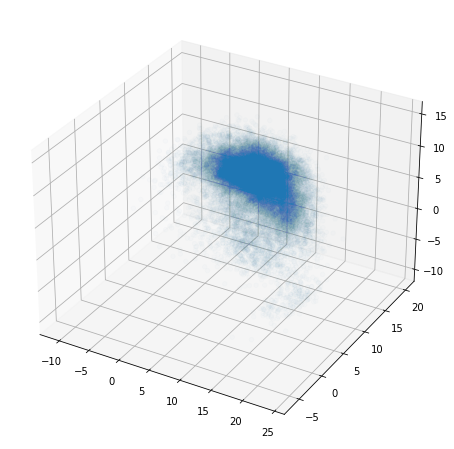

In [11]:
plt.figure(figsize = (10, 8))
plt_axes = plt.axes(projection = '3d')
plt_axes.scatter3D(x1, y1, z1, alpha=0.01)

<AxesSubplot:ylabel='Count'>

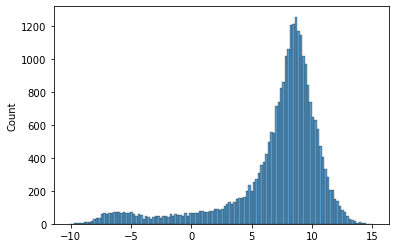

In [12]:
#d= np.linalg.norm(,axis=1)
sns.histplot(zp_ep_mp[:,9,2])

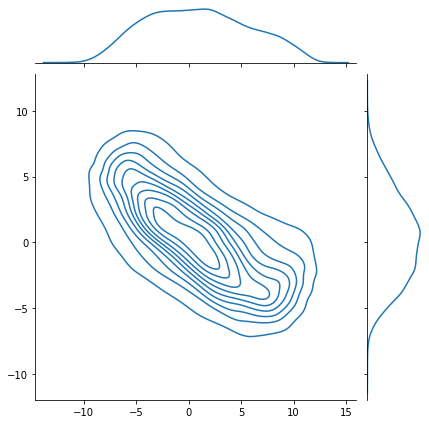

In [13]:
sns.jointplot(x=mpVec[:,0], y=mpVec[:,1], kind = 'kde')

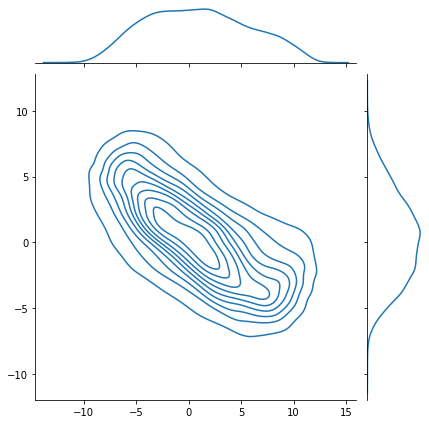

In [14]:
sns.jointplot(x=mpVec[:,0], y=mpVec[:,1], kind = 'kde')

In [219]:
#initiate array to hold endpoints
batch=100
helix_pairs = 10 #even number to reshape later
num_helices = 2
mi = 0 #master index

#random sample starting endpoints to buttress
refi_all = list(range(ep_mp.shape[0]))
ref_ind = np.array(random.sample(refi_all , batch))

#master_ep contains endpoints in original coordinates space
master_ep = ep_mp[ref_ind ,:4,...]

#starting concat special to orient points with original, helices to intialize directionality of addition (z refelect)
#points unused except for this orientation step and maintaining distance maps indexing
current_quad_prez = np.concatenate((ep_mp[ref_ind ,:4,...], ep_mp[ref_ind ,4:8,...]), axis=1)

current_quad = rotate_base_tri_Zplane(current_quad_prez,  target_point=4, index_mobile=[1,2,3])

start_dist = np.expand_dims(current_quad,axis=1) - np.expand_dims(current_quad,axis=2)
dist = np.sqrt(np.sum(start_dist**2, 3))
dist = dist.reshape((dist.shape[0],-1))

In [220]:
if tf.config.list_physical_devices('GPU'):
    device_name = tf.test.gpu_device_name()
else:
    device_name = 'CPU'
device_name = 'GPU' 
print(f'device name {device_name}')

device name GPU


In [221]:

gen="data/BestGenerator"

with tf.device(device_name):
    gen_obj = ge.BatchRecon(gen)
output1=gen_obj.generate(z=12,batch_size=12) #example generator

target_midpoint = tf.convert_to_tensor([7.0, 7.0, 9.0])

In [222]:
#will need to add method to convert helix 1,2,3,4 to just helix 1,2 (remove 1,2 convert 3,4 to )
ref_map_base = ref_distmap_index(dist, num_helices=4)

In [223]:
#%%time
#GPU ##33s  with 10*50000 start with 200 cycles
#CPU ##39s
output_z, loss_mask, loss_mp, batchInd=fullBUTT_GPU(gen_obj, ref_map_base , target_midpoint, batch_size=100,cycles=200, input_z=None, 
                          rate=0.05, target_ep=[4,5,6,7], num_helices=4, oneRef=True,
                          scale=100.0, z_size=12)


start_masked 7745.44
start_mp 11931.25
end_masked 244.83
end_mp 1051.63


In [234]:
# final_ep = buttress_ep_from_z(gen_obj, output_z[-1], current_quad, loss_mp[-1], loss_mask[-1], batchInd, 
#                               max_loss_mp=0.05, max_loss_mask=0.001)

(final_aligned, far), uInd =buttress_ep_from_z_mask_only(gen_obj, output_z[-1], current_quad_prez ,loss_mask[-1], batchInd, max_loss_mask = 0.0005,
                                 print_stats= True)

Input Size:  10000
Passing Filters:  1161


In [225]:
final_aligned[0]

array([[ -0.55,   2.05,  -0.43],
       [  4.21,  16.44,   8.89],
       [  5.77,  18.39,  -2.81],
       [  4.2 ,  -4.95, -11.71],
       [  9.17,  -2.75,  -2.1 ],
       [ 15.77,  19.22,  -4.55],
       [ 14.77,  17.09,   4.79],
       [ 10.43,   1.28,   8.21]])

In [228]:
np.round(current_quad_prez[uInd][0],1)

array([[ 0.3,  4.7,  1.3],
       [13.7,  7.1, 15.4],
       [20.7,  3.2, 12.6],
       [ 6. , -3.7, -5.3],
       [ 6.2, -9.7,  1.5],
       [ 2.4,  4. , 21. ],
       [10.5, -1. , 21.3],
       [15.7, -8.4,  7.4]])

In [236]:
#method to view points in pymol  
hf.HelicalProtein.makePointPDB(current_quad_prez[uInd][0],f't1.pdb',outDirec='output/')
hf.HelicalProtein.makePointPDB(final_aligned[0] ,f't2.pdb',outDirec='output/') 
hf.HelicalProtein.makePointPDB(far[0] ,f't3.pdb',outDirec='output/') 

1

In [87]:
def xform_to_superimpose_nposes( mobile, ref, index_mobile=[1,2,3],ref_resnum=[1,2,3] ):

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)

    z_plane_ref = np.repeat(np.array([[[0,0,0],[1,0,0],[1,1,0]]]), mobile.shape[0],axis=0)
    ref_stub = get_stubs_from_points(ref, index=ref_resnum)
    

    xform = ref_stub @ mobile_stub_inv

    return xform

def xform_npose_2batch(xform_in, npose_in):
    #single batch code  util.npose_util as xform_npose
    return np.matmul(np.repeat(xform_in[:,np.newaxis,...],npose_in.shape[1],axis=1),npose_in[...,None]).squeeze(-1)

In [80]:
current_quad.shape

(100, 8, 3)

In [81]:
master_ep.shape

(100, 4, 3)

In [47]:
#method to view points in pymol  
hf.HelicalProtein.makePointPDB(master_ep[uInd][0],f't1.pdb',outDirec='output/')

hf.HelicalProtein.makePointPDB(orig_coord_new_ep[0] ,f't2.pdb',outDirec='output/')    

1

In [307]:
npose = np.concatenate((final_zp_aligned, np.ones((final_zp_aligned.shape[0],
                                            final_zp_aligned[1],1))),axis=2) # add rotation dimension
orig_coord_new_ep = xform_npose_2batch(xform_inverse,npose)[...,:3] # remove rotation dimension

In [310]:
orig_coord_new_ep[3]

array([[  3.74,  13.3 ,   1.52],
       [-13.06,  12.62,  -0.55],
       [-10.55,  22.9 ,  -2.81],
       [ 14.54,  26.73,  -7.17],
       [  8.39,  18.45,  -4.2 ],
       [ -8.46,  19.68, -18.14],
       [-12.99,  15.83,  -9.17],
       [ -2.3 ,   5.62,  -0.54]])

In [347]:
current_quad[uInd][3]

array([[-0.83,  2.98,  0.86],
       [10.43, 13.66, 15.2 ],
       [15.56, 13.53, 13.64],
       [14.86,  7.09, -9.64],
       [16.02,  1.92, -6.13],
       [18.01,  0.47, 16.39],
       [10.28,  0.72, 12.49],
       [ 6.28, -3.2 , -7.89]])

In [ ]:
#concatenate new ep onto quad

In [222]:
#need just 4 ep per layer, aka 2 helix unit additions.
#master_ep = np.zeros((batch,4,3))
#seed with base two units, need distance map

mi = 0
master_ep = zp_ep_mp[ref_ind ,:4,...]


#distances indexed from generator are for helix quads
#though the unit here is technically helix pairs
#zeros are padded to maintain consistency for distance indices functions
current_quad = np.concatenate((master_ep,np.zeros_like(master_ep)), axis=1)

In [223]:
master_ep = np.concatenate((master_ep[uInd], final_ep[:,4:,...]), axis=1) #add endpoints to buttressed lest


In [226]:
mi=1
current_quad = np.concatenate((master_ep[:,mi*4:],np.zeros_like(master_ep[:,mi*4:])), axis=1)

In [227]:
current_quad[0]

array([[11.83,  4.  , -3.06],
       [-7.85, -8.03, -8.82],
       [-4.91, -8.82, -0.95],
       [ 7.38, -5.19, 10.82],
       [ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ]])

In [228]:
final_ep[0]

array([[ -1.87,   6.71,  -6.55],
       [-11.21,  -3.73,   1.3 ],
       [ -4.28,  -0.96,   9.06],
       [ 10.9 ,  16.01,  -1.81],
       [ 11.83,   4.  ,  -3.06],
       [ -7.85,  -8.03,  -8.82],
       [ -4.91,  -8.82,  -0.95],
       [  7.38,  -5.19,  10.82]])

In [69]:
npose = np.concatenate((new_zp_ep, np.ones((new_zp_ep.shape[0],
                                            new_zp_ep.shape[1],1))),axis=2) # add rotation dimension
inv_x = xform_to_superimpose_nposes( new_zp_ep, master_ep[uInd], index_mobile=[1,2,3],ref_resnum=[1,2,3] )

orig_coord_new_ep = xform_npose_2batch(inv_x,npose)[...,:3] # remove rotation dimension

NameError: name 'new_zp_ep' is not defined

In [343]:
orig_coord_new_ep[0]

array([[  9.12,   5.95,  -0.54],
       [ -8.31,   7.91,   6.58],
       [ -8.97,   3.65,  -2.58],
       [ 11.79,   0.34, -16.05],
       [ 10.87,  -4.44,  -6.8 ],
       [ -1.04,   0.51,  13.15],
       [ -1.27,  -9.1 ,  10.86],
       [-12.19,  -4.83,  -4.63]])

In [338]:
#method to view points in pymol  
hf.HelicalProtein.makePointPDB(orig_coord_new_ep[0][:4],f't1.pdb',outDirec='output/')
hf.HelicalProtein.makePointPDB(master_ep[uInd][0] ,f't2.pdb',outDirec='output/')    

1

In [345]:
master_ep[uInd][0]

array([[-0.83,  2.98,  0.86],
       [10.43, 13.66, 15.2 ],
       [15.56, 13.53, 13.64],
       [14.86,  7.09, -9.64]])

In [331]:
uInd

array([ 7, 36, 47, 47, 36,  9, 24, 97, 36,  7, 44, 17,  7, 47, 57, 26, 36,
       17,  9, 94, 97, 97, 36, 79, 63, 24, 57, 20, 17, 57, 52, 73, 58, 10,
       43, 57, 29, 19])

In [ ]:


def xform_to_z_plane(mobile, index_mobile=[0,1,2]):
    """rotate points into the z-plane for trilaterization. needs additional translation/reflection"""

    mobile_stub = get_stubs_from_points(mobile, index=index_mobile)
    mobile_stub_inv = np.linalg.inv(mobile_stub)
    
    z_plane_ref = np.repeat(np.array([[[0,0,0],[1,0,0],[1,1,0]]]), mobile.shape[0],axis=0)

    ref_stub = get_stubs_from_points(z_plane_ref, index=[0,1,2])

    xform = ref_stub @ mobile_stub_inv

    return xform


def rotate_base_tri_Zplane(endpoint_midpoints, target_point=4, index_mobile=[1,2,3], returnRotMat=False):
    """rotate points into the z-plane for trilaterization. Target point ensures that point is positive in Z"""
    tp = target_point #target point
    zplanexform = xform_to_z_plane(endpoint_midpoints,index_mobile=index_mobile) #one index start base triangle, default
    #add one for npose rot calc
    npose = np.concatenate((endpoint_midpoints, np.ones((endpoint_midpoints.shape[0],
                                                         endpoint_midpoints.shape[1],1))),axis=2) 
    rot = xform_npose_2batch(zplanexform,npose) # double batch matrix multiplication, see npose, for one batch

    #translate X domain to place first index of "index_mobile" to 0,0,0
    rot[:,:,0] = rot[:,:,0]-np.expand_dims(rot[:,index_mobile[0],0],axis=1)
    #based on target point guaranteed to be positive
    #reflect new points across the z axis to positive if negative to match just choosing positive solutions
    rot[...,2][rot[:,tp,2]<0] = -rot[...,2][rot[:,tp,2]<0]
    
    if not returnRotMat:
        return rot[...,:3] #remove npose rotate dimension
    else:
        return rot[...,:3], zplanexform

In [ ]:
#method to view points in pymol  
hf.HelicalProtein.makePointPDB(current_quad[uInd][0],f't1.pdb',outDirec='output/')
hf.HelicalProtein.makePointPDB(new_zp_ep[0] ,f't2.pdb',outDirec='output/')    